In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import matplotlib as mpl

import iblofunmatch.inter as ibfm
import os

from navground import core, sim

output_dir = "output"
os.makedirs("output", exist_ok=True)

EXECUTABLE_PATH: /home/atorras/repositories/navground-blofun/IBloFunMatch/build/IBloFunMatch


In [2]:
num_steps = 800
yaml = f"""
steps: {num_steps}
time_step: 0.1
record_safety_violation: true
record_task_events: true
record_pose: true
runs: 1
scenario:
  type: Cross
  radius: 5
  side: 11
  agent_margin: 0.15
  add_safety_to_agent_margin: true
  tolerance: 0.5
  position_noise: 0.2
  groups:
    - number: 18
      type: thymio
      control_period: 0.1
      behavior:
        type: HL
        safety_margin: 0.2
      radius: 0.15
      kinematics:
        type: 2WDiff
        max_speed: 1.0
        wheel_axis: 2
      state_estimation:
        type: Bounded
        range: 2.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()

In [3]:
run = experiment.runs[0]
ps = run.poses[:,:,[0,1]]
ps.shape

(800, 18, 2)

In [10]:
world = sim.World()
experiment.scenario.init_world(world, seed=10)
world.agents[0].behavior.barrier_angle

1.5707963705062866

In [4]:
def plot_two_timesteps(X, Y, ax, X_col="blue", Y_col="red"):
    # Plot figure
    ax.scatter(X[:,0], X[:,1], s=20, marker="s", c=X_col, zorder=2, label="X")
    ax.scatter(Y[:,0], Y[:,1], s=23, marker="x", c=Y_col, zorder=2, label="Y")
    for edge in zip(X, Y):
        edge_pts = np.array(edge)
        ax.plot(edge_pts[:,0], edge_pts[:,1], c="gray", zorder=1)

def plot_divergence_diagram(X, Y, ax):
    idx_S = list(range(int(X.shape[0])))
    # Compute distane matrices
    Dist_X = dist.squareform(dist.pdist(X))
    Dist_Y = dist.squareform(dist.pdist(Y))
    Dist_Z = np.minimum(Dist_X, Dist_Y)
    # Compute induced matchings
    ibfm_out = [
        ibfm.get_IBloFunMatch_subset(Dist_X, Dist_Z, idx_S, output_dir, max_rad=-1, num_it=1, store_0_pm=True, points=False, max_dim=1),
        ibfm.get_IBloFunMatch_subset(Dist_Y, Dist_Z, idx_S, output_dir, max_rad=-1, num_it=1, store_0_pm=True, points=False, max_dim=1)
    ]
    # Divergence diagrams 
    ibfm.plot_XYZ_matching_0(ibfm_out, ax)
    ax.set_xlim([-4,4])
    # print persistence divergence 
    matching_XZ = ibfm_out[0]["induced_matching_0"]
    matching_YZ = ibfm_out[1]["induced_matching_0"]
    composition_XY = [matching_YZ.index(i) for i in matching_XZ]
    endpoints_0 = np.array(ibfm_out[0]["S_barcode_0"][:,1])
    endpoints_1 = np.array(ibfm_out[1]["S_barcode_0"][:,1])
    endpoints_1 = endpoints_1[composition_XY]
    persistence_divergence = np.sum(np.sqrt((endpoints_0-endpoints_1)**2))
    # print(np.abs(endpoints_0-endpoints_1))
    # print(persistence_divergence)
    return ibfm_out

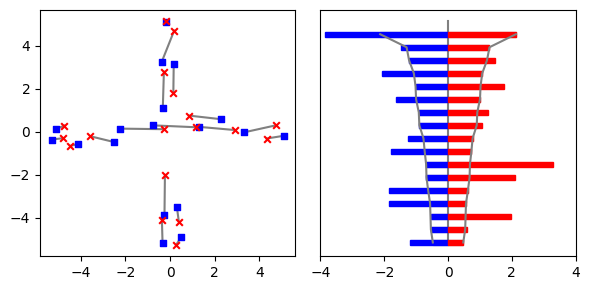

In [5]:
start_step = 250
X = ps[start_step]
Y = ps[start_step + 20]
X_len = X.shape[0]-1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
# Interpret diagram via points
plot_two_timesteps(X, Y, ax[0])
plot_divergence_diagram(X, Y, ax[1])
plt.tight_layout()
plt.savefig("first_exp_divergence.png")

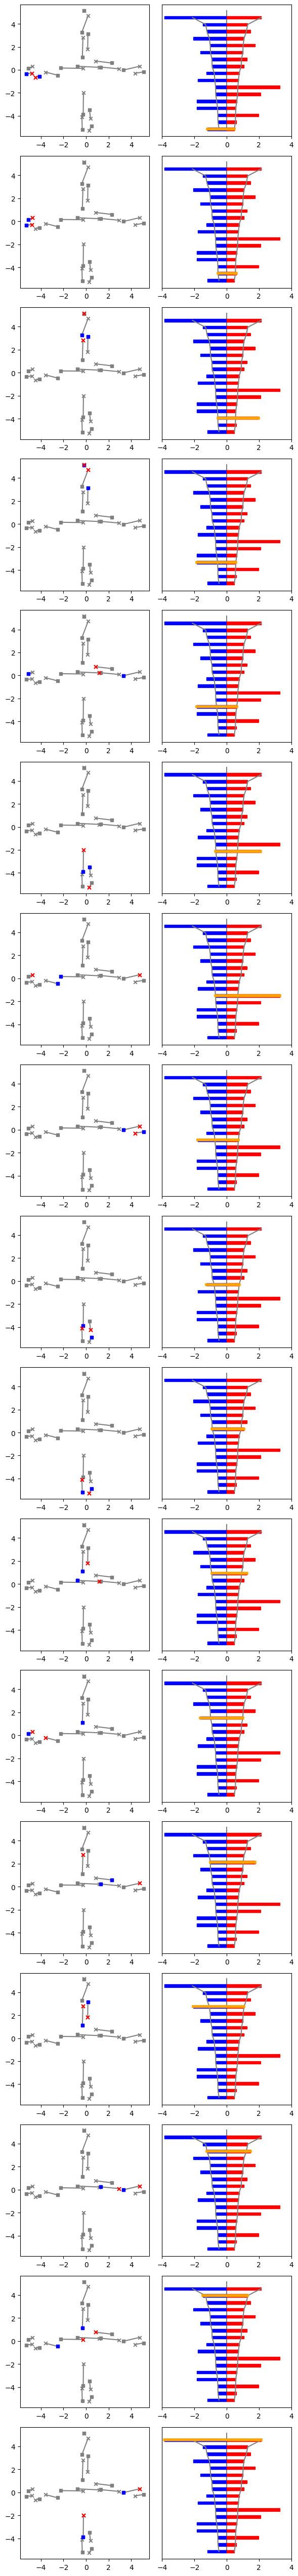

In [6]:
start_step = 250
X = ps[start_step]
Y = ps[start_step + 20]
X_len = X.shape[0]-1
fig, ax = plt.subplots(nrows=X_len, ncols=2, figsize=(6, 3*X_len))
# Interpret diagram via points
for idx_match in range(X_len):
    plot_two_timesteps(X, Y, ax[idx_match, 0], X_col="gray", Y_col="gray")
    ibfm_out = plot_divergence_diagram(X, Y, ax[idx_match, 1])
    idx_X = ibfm_out[0]["induced_matching_0"].index(idx_match)
    idx_Y = ibfm_out[1]["induced_matching_0"].index(idx_match)
    ax[idx_match, 1].plot([-ibfm_out[0]["S_barcode_0"][idx_X], ibfm_out[1]["S_barcode_0"][idx_Y]], [idx_match, idx_match], color="orange", linewidth=4)
    pts_X = X[ibfm_out[0]["S_reps_0"][idx_X]]
    pts_Y = Y[ibfm_out[1]["S_reps_0"][idx_Y]]
    # pts_Y = X[ibfm_out[0]["X_reps_0"][idx_match]]
    ax[idx_match, 0].scatter(pts_X[:,0], pts_X[:,1], c="blue", s=20, zorder=2, marker="s")
    ax[idx_match, 0].scatter(pts_Y[:,0], pts_Y[:,1], c="red", s=25, zorder=2.5, marker="x")
    # finish interpretation
    # ax[idx_match, 0].legend()
plt.tight_layout()

In [7]:
import scipy.spatial.distance as dist
import itertools
def plot_background_VR(a,b, ax, X, Y):
    # Points from X
    bool_smaller = dist.pdist(X)<a-1e-3
    edgelist = np.array([[i,j] for (i,j) in itertools.product(range(X.shape[0]), range(X.shape[0])) if i < j])[bool_smaller].tolist()
    for edge in edgelist:
        ax.plot(X[edge][:,0], X[edge][:,1], c="blue", zorder=0.5, linewidth=0.5)
    # Points in Y
    bool_smaller = dist.pdist(Y)<b-1e-3
    edgelist = np.array([[i,j] for (i,j) in itertools.product(range(Y.shape[0]), range(Y.shape[0])) if i < j])[bool_smaller].tolist()
    for edge in edgelist:
        ax.plot(Y[edge][:,0], Y[edge][:,1], c="red", zorder=0.5, linewidth=0.5)

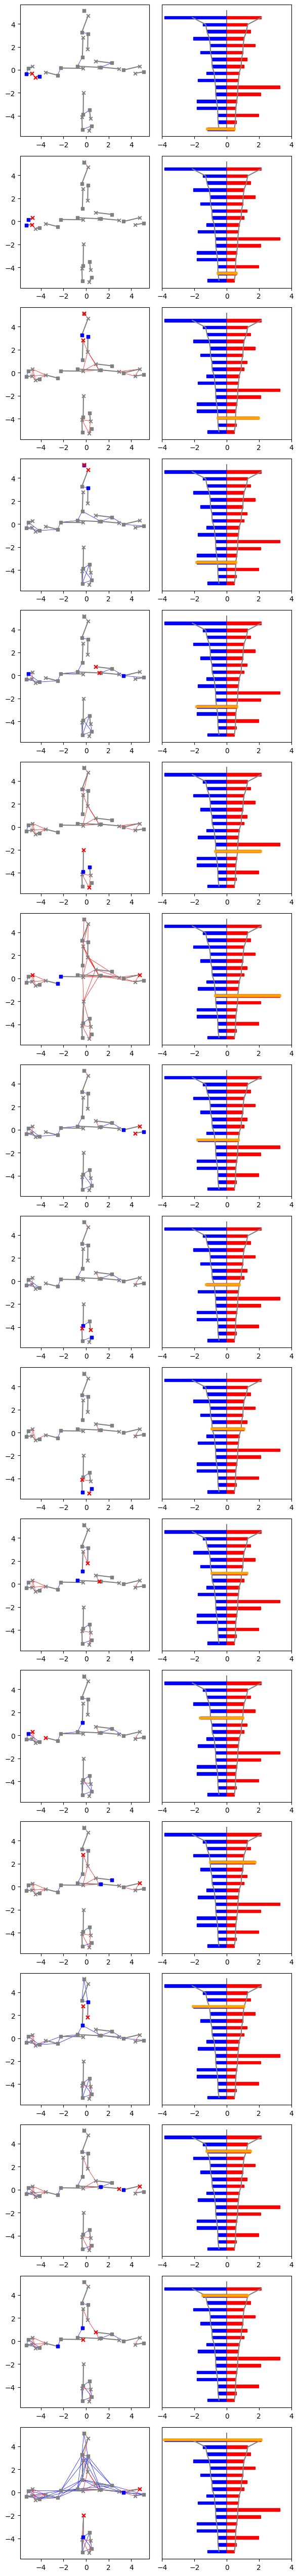

In [8]:
start_step = 250
X = ps[start_step]
Y = ps[start_step + 20]
X_len = X.shape[0]-1
fig, ax = plt.subplots(nrows=X_len, ncols=2, figsize=(6, 3*X_len))
# Interpret diagram via points
for idx_match in range(X_len):
    plot_two_timesteps(X, Y, ax[idx_match, 0], X_col="gray", Y_col="gray")
    ibfm_out = plot_divergence_diagram(X, Y, ax[idx_match, 1])
    idx_X = ibfm_out[0]["induced_matching_0"].index(idx_match)
    idx_Y = ibfm_out[1]["induced_matching_0"].index(idx_match)
    ax[idx_match, 1].plot([-ibfm_out[0]["S_barcode_0"][idx_X], ibfm_out[1]["S_barcode_0"][idx_Y]], [idx_match, idx_match], color="orange", linewidth=4)
    pts_X = X[ibfm_out[0]["S_reps_0"][idx_X]]
    idx_pts_X = ibfm_out[0]["S_reps_0"][idx_X] 
    a = ibfm_out[0]["S_barcode_0"][idx_X][1]
    b = ibfm_out[1]["S_barcode_0"][idx_Y][1]
    plot_background_VR(a,b, ax[idx_match,0], X, Y)
    # for idx_aux in range(idx_X):
    #     pts_aux = X[ibfm_out[0]["S_reps_0"][idx_aux]]
    #     ax[idx_match, 0].plot(pts_aux[:,0], pts_aux[:,1], c="blue")
    # for idx_aux in range(idx_Y):
    #     pts_aux = Y[ibfm_out[0]["S_reps_0"][idx_aux]]
    #     ax[idx_match, 0].plot(pts_aux[:,0], pts_aux[:,1], c="red")
    pts_Y = Y[ibfm_out[1]["S_reps_0"][idx_Y]]
    # pts_Y = X[ibfm_out[0]["X_reps_0"][idx_match]]
    ax[idx_match, 0].scatter(pts_X[:,0], pts_X[:,1], c="blue", s=20, zorder=2, marker="s")
    ax[idx_match, 0].scatter(pts_Y[:,0], pts_Y[:,1], c="red", s=25, zorder=2.5, marker="x")
    # finish interpretation
    # ax[idx_match, 0].legend()
plt.tight_layout()

In [9]:
ibfm.plot_geometric_matching

<function iblofunmatch.inter.plot_geometric_matching(a, b, idx_S, X, ibfm_out, ax, _tol=1e-05, labelsize=10)>

In [10]:
def compute_divergence_vector(X, Y):
    idx_S = list(range(int(X.shape[0])))
    # Compute distane matrices
    Dist_X = dist.squareform(dist.pdist(X))
    Dist_Y = dist.squareform(dist.pdist(Y))
    Dist_Z = np.minimum(Dist_X, Dist_Y)
    # Compute matching
    ibfm_out = [
        ibfm.get_IBloFunMatch_subset(Dist_X, Dist_Z, idx_S, output_dir, max_rad=-1, num_it=1, store_0_pm=True, points=False, max_dim=1),
        ibfm.get_IBloFunMatch_subset(Dist_Y, Dist_Z, idx_S, output_dir, max_rad=-1, num_it=1, store_0_pm=True, points=False, max_dim=1)
    ]
    # Compute induced matchings
    matching_XZ = ibfm_out[0]["induced_matching_0"]
    matching_YZ = ibfm_out[1]["induced_matching_0"]
    composition_XY = [matching_YZ.index(i) for i in matching_XZ]
    endpoints_0 = np.array(ibfm_out[0]["S_barcode_0"][:,1])
    endpoints_1 = np.array(ibfm_out[1]["S_barcode_0"][:,1])
    endpoints_1 = endpoints_1[composition_XY]
    return endpoints_0 - endpoints_1, ibfm_out[0]["X_barcode_0"][:,1]

In [11]:
divergence_list = []
Z_barcodes_list = []
for start_step in range(550):
    X = ps[start_step]
    Y = ps[start_step + 20]
    divergence, Z_barcode = compute_divergence_vector(X, Y)
    divergence_list.append(divergence)
    Z_barcodes_list.append(Z_barcode)

divergence_arr = np.array(divergence_list).transpose()
Z_barcodes_arr = np.array(Z_barcodes_list).transpose()


AxesImage(shape=(17, 550))
3.4702439999999997


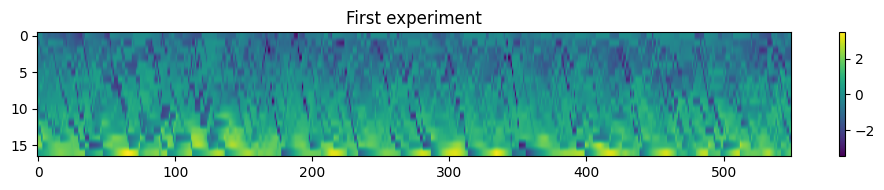

In [12]:
fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(divergence_arr)
mapable = ax.imshow(divergence_arr, aspect="auto", vmax=vmax)
print(mapable)
print(np.max(divergence_arr))
ax.set_title("First experiment")
plt.colorbar(mapable)
plt.tight_layout()
plt.savefig("first_divergence_diag_hist.png")

We also consider a way of plotting divergence which is continuous.

In [13]:
divergence_arr.shape

(17, 550)

In [14]:
Z_barcodes_arr.shape

(17, 550)

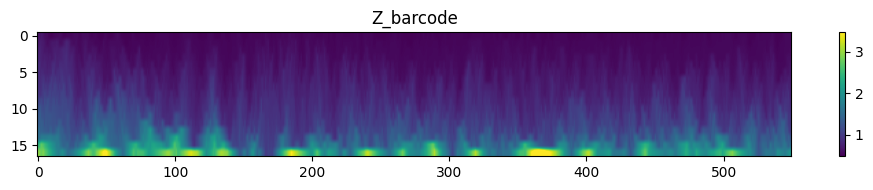

In [15]:
fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(divergence_arr)
mapable = ax.imshow(Z_barcodes_arr, aspect="auto", vmax=vmax)
ax.set_title("Z_barcode")
plt.colorbar(mapable)
plt.tight_layout()

Combine both

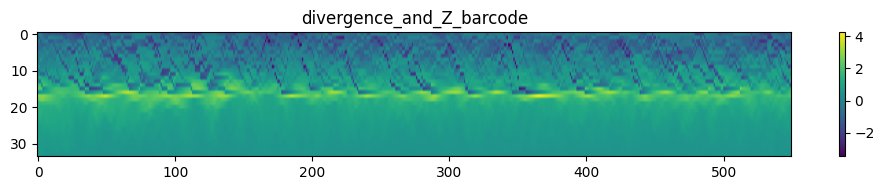

In [16]:
fig, ax = plt.subplots(figsize=(10,2))
combination = np.vstack([divergence_arr, Z_barcodes_arr[range(Z_barcodes_arr.shape[0]-1, -1, -1)]])
vmax = np.max(combination)
mapable = ax.imshow(combination, aspect="auto", vmax=vmax)
ax.set_title("divergence_and_Z_barcode")
plt.colorbar(mapable)
plt.tight_layout()

In [17]:
cumulative_list = []
for j, divergence in enumerate(divergence_arr.transpose()):
    cumulative = []
    for i in range(divergence_arr.shape[0]):
        cumulative.append(np.sum(divergence[:i+1]))
    cumulative_list.append(cumulative)
cumulative_arr = np.array(cumulative_list).transpose()

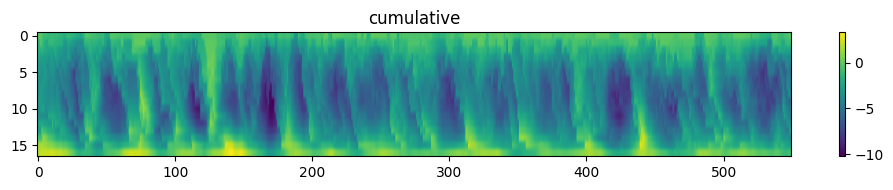

In [18]:
fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(cumulative_arr)
vmin = np.min(cumulative_arr)
mapable = ax.imshow(cumulative_arr, aspect="auto", vmax=vmax, vmin=vmin)
ax.set_title("cumulative")
plt.colorbar(mapable)
plt.tight_layout()

In [19]:
y_max = np.max(Z_barcodes_arr)
y_min = np.min(Z_barcodes_arr)
y_range = np.linspace(y_min, y_max, 10)
combinations_list = []
for y in y_range:
    combinations_row = [] 
    for j, column in enumerate(Z_barcodes_arr.transpose()):
        idx = np.sum(Z_barcodes_arr[:,j] < y)-1
        if idx < 0:
            combinations_row.append(0)
        else:
            combinations_row.append(cumulative_arr[idx,j])
    combinations_list.append(combinations_row)
combinations_arr = np.array(combinations_list)

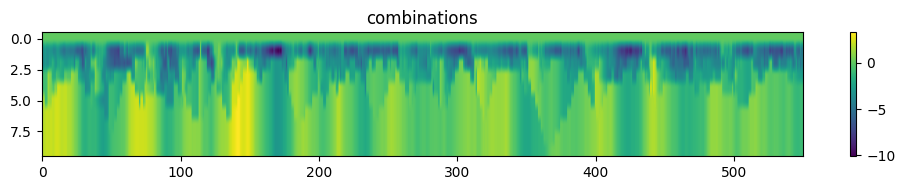

In [20]:
fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(combinations_arr)
vmin = np.min(combinations_arr)
mapable = ax.imshow(combinations_arr, aspect="auto", vmax=vmax, vmin=vmin)
ax.set_title("combinations")
plt.colorbar(mapable)
plt.tight_layout()

# Deadlock experiment

In [21]:
num_steps = 600
yaml = f"""
steps: {num_steps}
time_step: 0.1
record_safety_violation: true
record_task_events: true
record_pose: true
runs: 1
scenario:
  type: Cross
  radius: 5
  side: 11
  agent_margin: 0.15
  add_safety_to_agent_margin: true
  tolerance: 0.5
  position_noise: 0.2
  groups:
    - number: 18
      type: thymio
      control_period: 0.1
      behavior:
        type: HL
        safety_margin: 0.5
      radius: 0.15
      kinematics:
        type: 2WDiff
        max_speed: 1.0
        wheel_axis: 2
      state_estimation:
        type: Bounded
        range: 2.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
run = experiment.runs[0]
ps = run.poses[:,:,[0,1]]
ps.shape

(600, 18, 2)

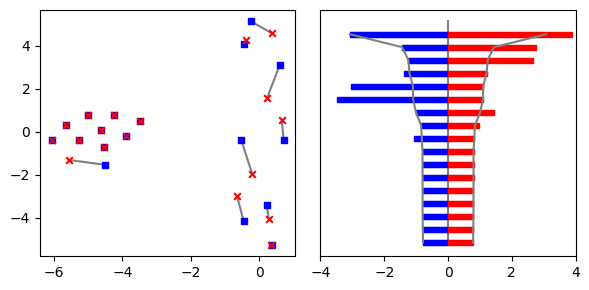

In [22]:
start_step = 550
X = ps[start_step]
Y = ps[start_step + 20]
X_len = X.shape[0]-1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
# Interpret diagram via points
plot_two_timesteps(X, Y, ax[0])
plot_divergence_diagram(X, Y, ax[1])
plt.tight_layout()
plt.savefig("second_exp_divergence.png")

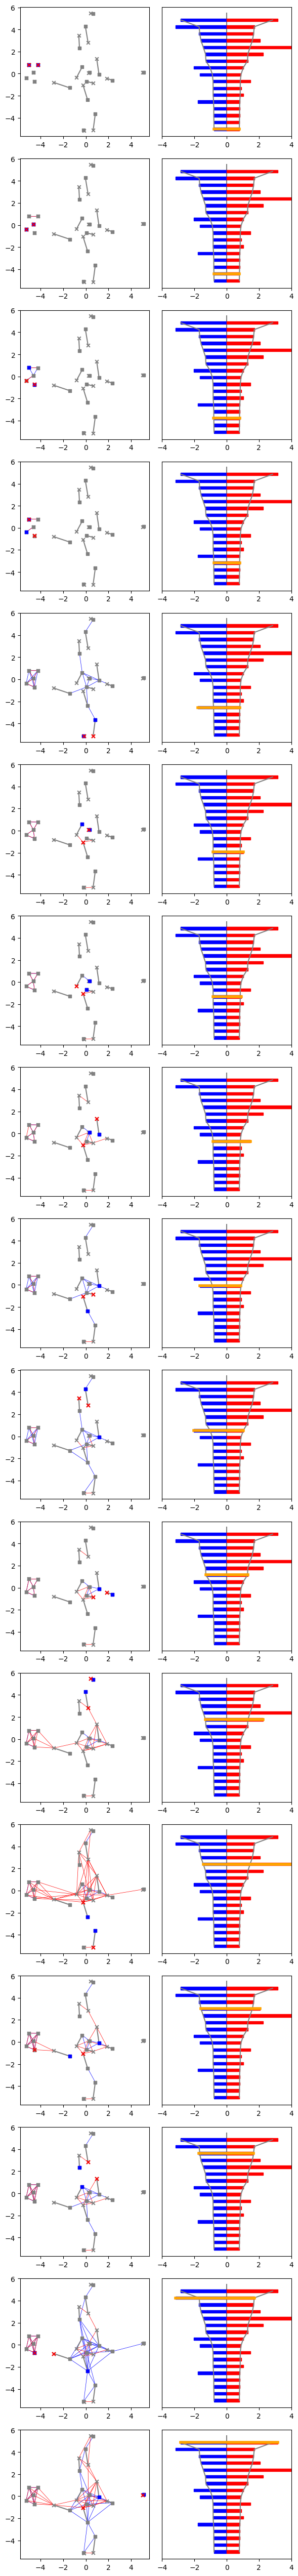

In [23]:
X = ps[290]
Y = ps[310]
X_len = X.shape[0]-1
fig, ax = plt.subplots(nrows=X_len, ncols=2, figsize=(6, 3*X_len))
# Interpret diagram via points
for idx_match in range(X_len):
    plot_two_timesteps(X, Y, ax[idx_match, 0], X_col="gray", Y_col="gray")
    ibfm_out = plot_divergence_diagram(X, Y, ax[idx_match, 1])
    idx_X = ibfm_out[0]["induced_matching_0"].index(idx_match)
    idx_Y = ibfm_out[1]["induced_matching_0"].index(idx_match)
    ax[idx_match, 1].plot([-ibfm_out[0]["S_barcode_0"][idx_X], ibfm_out[1]["S_barcode_0"][idx_Y]], [idx_match, idx_match], color="orange", linewidth=4)
    pts_X = X[ibfm_out[0]["S_reps_0"][idx_X]]
    pts_Y = Y[ibfm_out[1]["S_reps_0"][idx_Y]]
    # pts_Y = X[ibfm_out[0]["X_reps_0"][idx_match]]
    a = ibfm_out[0]["S_barcode_0"][idx_X][1]
    b = ibfm_out[1]["S_barcode_0"][idx_Y][1]
    plot_background_VR(a,b, ax[idx_match,0], X, Y)
    ax[idx_match, 0].scatter(pts_X[:,0], pts_X[:,1], c="blue", s=20, zorder=2, marker="s")
    ax[idx_match, 0].scatter(pts_Y[:,0], pts_Y[:,1], c="red", s=25, zorder=2.5, marker="x")
    # finish interpretation
    # ax[idx_match, 0].legend()
plt.tight_layout()

In [24]:
divergence_list = []
for start_step in range(550):
    X = ps[start_step]
    Y = ps[start_step + 20]
    divergence, Z_barcode = compute_divergence_vector(X, Y)
    divergence_list.append(divergence)

divergence_arr = np.array(divergence_list).transpose()


AxesImage(shape=(17, 550))


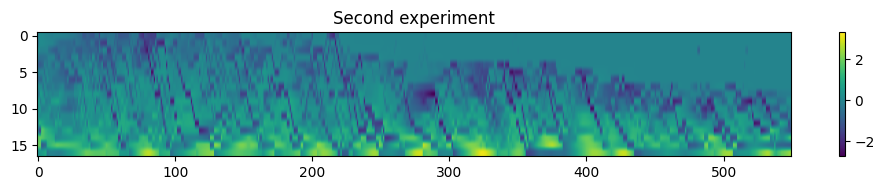

In [25]:
fig, ax = plt.subplots(figsize=(10,2))
mapable = ax.imshow(divergence_arr, aspect="auto", vmax=vmax)
print(mapable)
ax.set_title("Second experiment")
plt.colorbar(mapable)
plt.tight_layout()
plt.savefig("second_divergence_diag_hist.png")

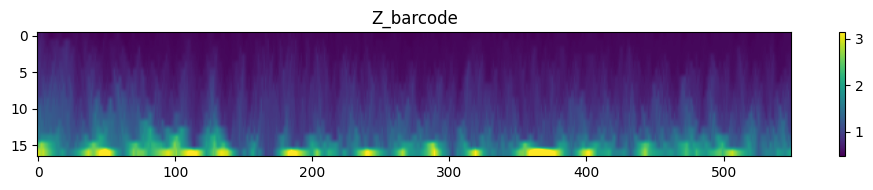

In [26]:
fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(divergence_arr)
mapable = ax.imshow(Z_barcodes_arr, aspect="auto", vmax=vmax)
ax.set_title("Z_barcode")
plt.colorbar(mapable)
plt.tight_layout()

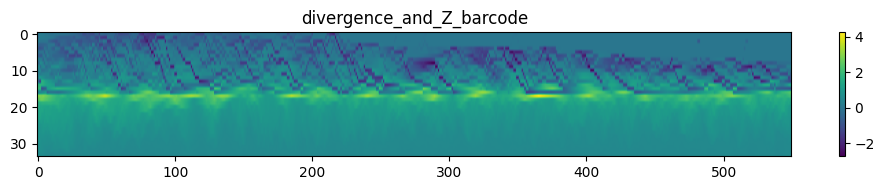

In [27]:
fig, ax = plt.subplots(figsize=(10,2))
combination = np.vstack([divergence_arr, Z_barcodes_arr[range(Z_barcodes_arr.shape[0]-1, -1, -1)]])
vmax = np.max(combination)
mapable = ax.imshow(combination, aspect="auto", vmax=vmax)
ax.set_title("divergence_and_Z_barcode")
plt.colorbar(mapable)
plt.tight_layout()

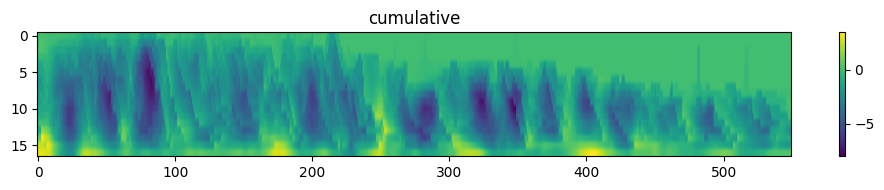

In [28]:
cumulative_list = []
for j, divergence in enumerate(divergence_arr.transpose()):
    cumulative = []
    for i in range(divergence_arr.shape[0]):
        cumulative.append(np.sum(divergence[:i+1]))
    cumulative_list.append(cumulative)
cumulative_arr = np.array(cumulative_list).transpose()

fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(cumulative_arr)
vmin = np.min(cumulative_arr)
mapable = ax.imshow(cumulative_arr, aspect="auto", vmax=vmax, vmin=vmin)
ax.set_title("cumulative")
plt.colorbar(mapable)
plt.tight_layout()

In [29]:
y_max = np.max(Z_barcodes_arr)
y_min = np.min(Z_barcodes_arr)
y_range = np.linspace(y_min, y_max, 10)
combinations_list = []
for y in y_range:
    combinations_row = [] 
    for j, column in enumerate(Z_barcodes_arr.transpose()):
        idx = np.sum(Z_barcodes_arr[:,j] < y)-1
        if idx < 0:
            combinations_row.append(0)
        else:
            combinations_row.append(cumulative_arr[idx,j])
    combinations_list.append(combinations_row)
combinations_arr = np.array(combinations_list)

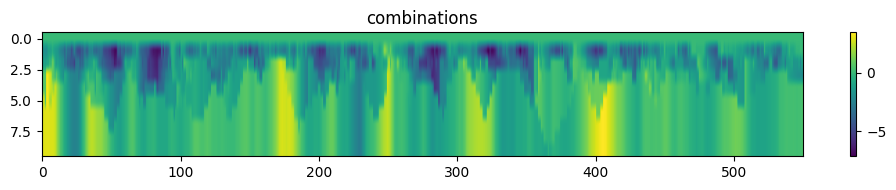

In [30]:
fig, ax = plt.subplots(figsize=(10,2))
vmax = np.max(combinations_arr)
vmin = np.min(combinations_arr)
mapable = ax.imshow(combinations_arr, aspect="auto", vmax=vmax, vmin=vmin)
ax.set_title("combinations")
plt.colorbar(mapable)
plt.tight_layout()